In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
### Let's read a sample audio using librosa
import librosa 
audio_file_path='UrbanSound8K/6988-5-0-3.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [3]:
print(librosa_audio_data)

[-0.5025788  -0.7330911  -0.63469875 ...  0.19002673  0.14900687
  0.14226592]


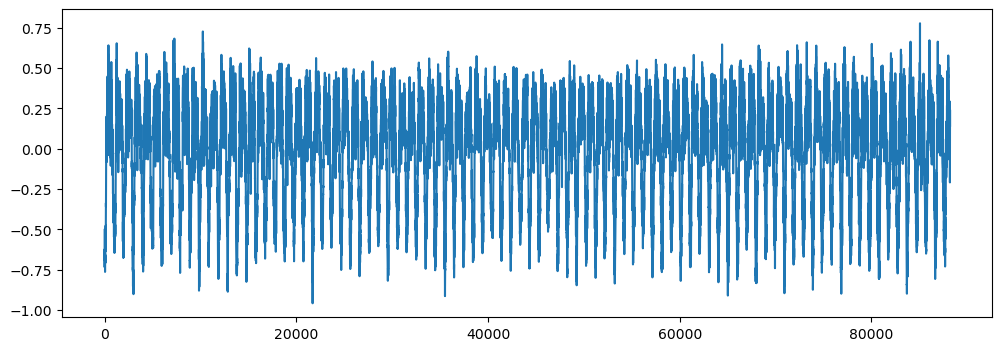

In [4]:
### Lets plot the librosa audio data
import matplotlib.pyplot as plt
# Original audio with 1 channel
plt.figure(figsize=(12,4))
plt.plot(librosa_audio_data)

In [5]:
### Lets read with scipy
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path)


In [6]:
wave_audio

array([[-21332, -23261],
       [-21135, -23440],
       [-20853, -23675],
       ...,
       [  3609,   5553],
       [  3623,   5119],
       [  3776,   5151]], dtype=int16)

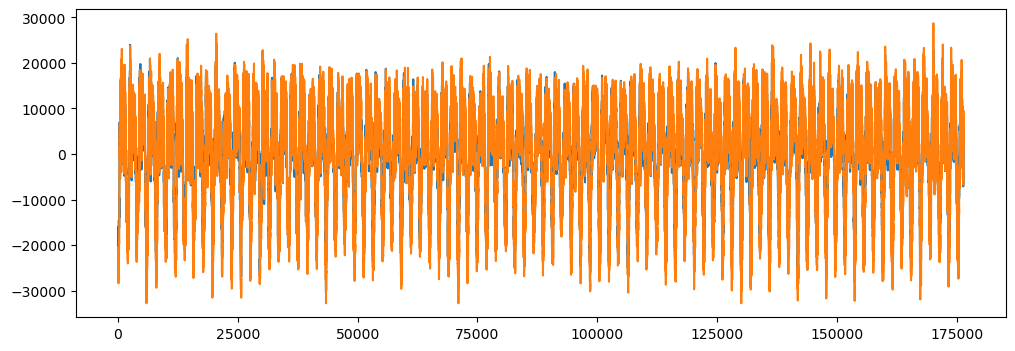

In [7]:
import matplotlib.pyplot as plt

#Original audio with 2 channels
plt.figure(figsize=(12,4)) 
plt.plot(wave_audio)

# Extract Features

Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characterstics of the sound. These audio representations will allow us to identify features for classification.

In [8]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [9]:
mfccs

array([[-6.8388161e+01, -7.3425034e+01, -9.2049835e+01, ...,
        -8.5876747e+01, -8.2391006e+01, -8.7416954e+01],
       [ 1.2436899e+02,  1.4745334e+02,  1.6406967e+02, ...,
         1.6844672e+02,  1.5890938e+02,  1.4584236e+02],
       [ 6.9833940e-01, -1.3157434e+01, -2.7969656e+01, ...,
        -4.9139599e+01, -4.5604294e+01, -2.9129078e+01],
       ...,
       [ 3.8311865e+00,  4.8636228e-02,  1.8295286e+00, ...,
         5.4839640e+00,  6.3941441e+00,  8.0453472e+00],
       [ 4.4831002e-01,  3.2497563e+00,  1.4445057e+00, ...,
         4.9681611e+00,  5.7134974e-01,  3.2036922e+00],
       [ 1.4581232e+00,  6.0481892e+00, -2.5549346e-01, ...,
         1.6492350e+00,  4.1517496e+00,  6.2502394e+00]], dtype=float32)

In [10]:
#### Extracting MFCC's for every audio file
import pandas as pd 
import os 
import librosa

audio_dataset_path='UrbanSound8K/audio/'
metadata=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [11]:
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [12]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [13]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

8732it [07:00, 20.77it/s]


In [14]:
### converting extracted_features to pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['features','class'])
extracted_features_df.head()

,features,class
0,"[-217.35526, 70.22339, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",children_playing


In [15]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['features'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [16]:
X.shape

(8732, 40)

In [18]:
### label Encoding
#y=np.array(pd.get_dummies(y))
### Label Encoder

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))



In [19]:
y.shape

(8732, 10)

In [20]:
### train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [21]:
X_train.shape

(6985, 40)

In [22]:
X_test.shape

(1747, 40)

In [23]:
y_train.shape

(6985, 10)

In [24]:
y_test.shape

(1747, 10)

In [25]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

# Model Creation

In [26]:

import tensorflow as tf
print(tf.__version__)

2.15.0


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [28]:
### No of classes
num_labels=y.shape[1]

In [29]:
#Dense(1)

In [30]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third Layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final Layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [32]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [33]:
## Training my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', verbose=1, save_best_only=True)
 
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer])


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100


219/219 [==============================] - ETA: 0s - loss: 12.5068 - accuracy: 0.1194
Epoch 1: val_loss improved from inf to 2.29299, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 2s 3ms/step - loss: 12.5068 - accuracy: 0.1194 - val_loss: 2.2930 - val_accuracy: 0.1214
Epoch 2/100
194/219 [=========================>....] - ETA: 0s - loss: 2.5910 - accuracy: 0.1121
Epoch 2: val_loss improved from 2.29299 to 2.28099, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 2ms/step - loss: 2.5727 - accuracy: 0.1130 - val_loss: 2.2810 - val_accuracy: 0.1139
Epoch 3/100
218/219 [============================>.] - ETA: 0s - loss: 2.3584 - accuracy: 0.1188
Epoch 3: val_loss improved from 2.28099 to 2.27141, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 2ms/step - loss: 2.3582 - accuracy: 0.1191 - val_loss: 2.2714 - val_accuracy: 0.

Epoch 24/100
216/219 [============================>.] - ETA: 0s - loss: 1.7176 - accuracy: 0.3572
Epoch 24: val_loss improved from 1.56794 to 1.53068, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 2ms/step - loss: 1.7184 - accuracy: 0.3578 - val_loss: 1.5307 - val_accuracy: 0.4551
Epoch 25/100
218/219 [============================>.] - ETA: 0s - loss: 1.7052 - accuracy: 0.3783
Epoch 25: val_loss improved from 1.53068 to 1.48987, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 2ms/step - loss: 1.7058 - accuracy: 0.3781 - val_loss: 1.4899 - val_accuracy: 0.4865
Epoch 26/100
213/219 [============================>.] - ETA: 0s - loss: 1.6522 - accuracy: 0.3878
Epoch 26: val_loss improved from 1.48987 to 1.47645, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 2ms/step - loss: 1.6492 - accuracy: 0.3898 - val_loss: 1.4764 - val_accura

219/219 [==============================] - 0s 2ms/step - loss: 1.2126 - accuracy: 0.5898 - val_loss: 1.0122 - val_accuracy: 0.6737
Epoch 50/100
196/219 [=========================>....] - ETA: 0s - loss: 1.1890 - accuracy: 0.5957
Epoch 50: val_loss improved from 1.00599 to 0.98529, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 2ms/step - loss: 1.1855 - accuracy: 0.5977 - val_loss: 0.9853 - val_accuracy: 0.6829
Epoch 51/100
191/219 [=========================>....] - ETA: 0s - loss: 1.1820 - accuracy: 0.6003
Epoch 51: val_loss did not improve from 0.98529
219/219 [==============================] - 0s 2ms/step - loss: 1.1820 - accuracy: 0.6013 - val_loss: 1.0029 - val_accuracy: 0.6737
Epoch 52/100
196/219 [=========================>....] - ETA: 0s - loss: 1.2058 - accuracy: 0.5886
Epoch 52: val_loss did not improve from 0.98529
219/219 [==============================] - 0s 2ms/step - loss: 1.2012 - accuracy: 0.5910 - val_loss: 1.0164 -

219/219 [==============================] - 0s 2ms/step - loss: 1.0431 - accuracy: 0.6464 - val_loss: 0.8535 - val_accuracy: 0.7264
Epoch 77/100
204/219 [==========================>...] - ETA: 0s - loss: 1.0349 - accuracy: 0.6536
Epoch 77: val_loss did not improve from 0.84829
219/219 [==============================] - 0s 2ms/step - loss: 1.0307 - accuracy: 0.6545 - val_loss: 0.8500 - val_accuracy: 0.7390
Epoch 78/100
207/219 [===========================>..] - ETA: 0s - loss: 1.0288 - accuracy: 0.6564
Epoch 78: val_loss improved from 0.84829 to 0.83172, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 0s 2ms/step - loss: 1.0289 - accuracy: 0.6561 - val_loss: 0.8317 - val_accuracy: 0.7430
Epoch 79/100
203/219 [==========================>...] - ETA: 0s - loss: 1.0273 - accuracy: 0.6569
Epoch 79: val_loss did not improve from 0.83172
219/219 [==============================] - 0s 2ms/step - loss: 1.0356 - accuracy: 0.6530 - val_loss: 0.8504 -

In [34]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7521465420722961


In [35]:
filename="UrbanSound8k/car_horn.wav"
prediction_feature=features_extractor(filename)
prediction_feature=prediction_feature.reshape(1,-1)


np.argmax(model.predict(prediction_feature), axis=1)

1/1 [==============================] - 0s 100ms/step


array([9], dtype=int64)

In [36]:

np.argmax(model.predict(X_test), axis=1)

55/55 [==============================] - 0s 1ms/step


array([5, 3, 4, ..., 9, 2, 0], dtype=int64)

# Testing Some Test Audio Data
steps
    . Preprocess the new audio data
    . predict the classes
    . Invere transform your Predicted Label

In [37]:
from sklearn import preprocessing

In [39]:
filename="C:/Users/Lenovo/Music/download/children_playing.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
predicted_label = predicted_label.reshape(1,-1)

print(predicted_label)

prediction_class = labelencoder.inverse_transform(np.argmax(predicted_label, axis=1))


print("Predicted class:", prediction_class[0])


[-2.1032658e+02  1.0417866e+02 -4.8686050e+01  5.0608349e+01
 -1.0147294e+01  2.2865330e+01 -6.4224529e+00  7.3837962e+00
  2.6748497e+00  1.1393963e+01  5.0605311e+00  2.1316916e+01
  7.8362188e+00  6.5950766e+00 -2.2719500e+00  7.8155370e+00
  3.1804433e+00  5.1726041e+00 -3.7955842e+00 -4.6692237e-01
  1.7853823e+00  8.0194540e+00  2.9354553e+00 -3.5768613e-01
 -1.1977713e+00  1.7760172e+00 -2.2242475e+00  1.7574136e+00
  1.9999350e+00  4.3096890e+00 -2.1221983e-01  1.3709489e+00
  9.2991337e-02 -1.1136234e+00 -3.5919683e+00 -4.1539512e+00
 -2.8942981e+00  9.4044894e-01 -1.5671059e+00 -1.1189530e+00]
[[-2.1032658e+02  1.0417866e+02 -4.8686050e+01  5.0608349e+01
  -1.0147294e+01  2.2865330e+01 -6.4224529e+00  7.3837962e+00
   2.6748497e+00  1.1393963e+01  5.0605311e+00  2.1316916e+01
   7.8362188e+00  6.5950766e+00 -2.2719500e+00  7.8155370e+00
   3.1804433e+00  5.1726041e+00 -3.7955842e+00 -4.6692237e-01
   1.7853823e+00  8.0194540e+00  2.9354553e+00 -3.5768613e-01
  -1.1977713e+00 